# Chapter 5. Dynamical Analysis of Echo State Network

In this chapter, you will learn the fundamental knowledge about dynamical systems, which is essential for understanding RC.
Building on this, we will analyze ESNs from the perspective of dynamical systems and explore their relationship with the echo state property (ESP).

## Introduction

A **dynamical system**<sup>[1, 2]</sup> refers to a system whose state changes over time according to a certain rule.
A dynamical system defined in discrete time $k \in \mathbb{Z}$ is called a **discrete dynamical system**, and its time evolution is represented by a difference equation using the $N$-dimensional state $x \in \mathbb{R}^N$ and the map $f: \mathbb{R}^N \to \mathbb{R}^N$:

$$
\begin{align*}
x[k+1] = f(x[k]) \tag{I}
.\end{align*}
$$

On the other hand, a dynamical system defined in continuous time $t \in \mathbb{R}$ is called a **continuous dynamical system**, and its time evolution is represented by a differential equation of the following form:

$$
\begin{align*}
\frac{dx}{dt}(t) = f(x(t)) \tag{II}
.\end{align*}
$$

In either case, the evolution rule of the dynamical system is, in principle, deterministic, meaning that the future state can be uniquely determined from the current state.
Therefore, if the initial state $x[0]$ or $x(0)$ is known, the state $x$ at any (future) time can be obtained by iteratively computing equations (I) or (II).
The temporal evolution of the state $x$ is also called a **trajectory**.
The set of all possible values that the state $x$ can take is called the **phase space**, which corresponds to $\mathbb{R}^N$ in this formulation.

The ESN that we have studied so far is also a system whose internal state evolves over time according to a certain rule, and can be formulated as the above dynamical system equations when inputs are not considered.
Therefore, many analysis methods used in the field of dynamical systems can be useful for understanding and analyzing the behavior of ESNs.
This chapter focuses on the following topics to deepen the understanding of ESNs as dynamical systems:
- What behavior does an ESN converge to when run for a long time? (Attractors)
- How does the behavior of an ESN change when its parameters are altered? (Bifurcations)
- How does the behavior of an ESN depend on its initial state? (Chaos, Lyapunov exponents)
- Under which conditions can we fully utilize the information processing capabilities of ESNs? (Properties of non-autonomous dynamical systems, ESP)

## Exercises and demonstrations

Please execute the following cell to import the `ESN` and `Linear` classes that we implemented previously, as well as the basic libraries.
You can check the internal implementations of `ESN` and `Linear` either by uncommenting the lines after `import inspect` or by using `...?? / ??...`.

In [ ]:
import sys

import matplotlib.patches as patches
import numpy as np

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch en_sol https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.reservoir import ESN, Linear
from utils.style_config import Figure, plt
from utils.tester import load_from_chapter_name
from utils.tqdm import tqdm, trange
from utils.viewer import show_3d_coord

test_func, show_solution = load_from_chapter_name("05_esn_dynamics")

# Uncomment it to see the implementations of `Linear` and `ESN`.
# import inspect
# print(inspect.getsource(Linear))
# print(inspect.getsource(ESN))

# Or just use ??.../...?? (uncomment the following lines).
# Linear??
# ESN??

### 1. Types of attractors

An **attractor** is a region in a dynamical system's phase space to which its trajectory will converge to after some time.
Once the system's trajectory is drawn into an attractor, it will never escape unless a large perturbation is applied.
When a dynamical system has an attractor, most trajectories will ultimately be drawn into the attractor, meaning that it essentially governs the long-term behavior of the system.
Therefore, in the field of dynamical systems, the properties and analysis of attractors are given particular importance.

The **Hénon map** is a two-dimensional discrete dynamical system proposed by the French astronomer M. Hénon in 1976.
Depending on the values of its parameters, this system converges to different types of attractors and can exhibit complex behavior despite being represented by simple equations.
Specifically, the temporal evolution of the Hénon map is given by the following equations:

$$
\begin{align*}
x[k+1] &= 1 - a x[k]^2 + y[k] \\
y[k+1] &= bx[k]
.\end{align*}
$$

- $k \in \mathbb{Z}$: Discrete time
- $x[k], y[k] \in \mathbb{R}$: System state
- $a, b \in \mathbb{R}$: Parameters (constants)

Q1.1.

Fill in the following blanks to implement the function `henon_func` that calculates the state of the Hénon map at the next time step from the current state.
The state of the system should be represented by a single variable $z := [x \quad y]^\top \in \mathbb{R}^2$, and the function `henon_func` should be capable of batch processing using a multidimensional array $Z \in \mathbb{R}^{... \times 2}$ containing multiple states.

- `henon_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 2)`
  - Return(s):
    - `z_out`: `np.ndarray`
      - `shape`: `(..., 2)`

In [ ]:
def henon_func(z, a=1.4, b=0.3):
    assert z.shape[-1] == 2
    z_out = np.zeros_like(z)
    z_out[..., 0] = 1.0 - a * (z[..., 0] ** 2) + z[..., 1]  # TODO
    z_out[..., 1] = b * z[..., 0]  # TODO
    return z_out


test_func(henon_func, "01_01")
# show_solution("01_01", "henon_func")  # Uncomment it to see the solution.

#### Fixed points

A **fixed point** is a point in the phase space that does not move over time.
For a discrete dynamical system, a fixed point $x^*$ satisfies $x[k+1] = x[k]$, or $x^* = f(x^*)$.
There are stable fixed points, where nearby trajectories are attracted to the fixed point, and unstable fixed points, where they are repelled away from.
Stable fixed points are attractors.

The Hénon map has a fixed point attractor with the parameter values $a = 0$ and $b = 0.3$.
Below is the code to display this fixed point and the dynamics leading to it.

In [ ]:
a, b = 0.0, 0.3
length = 21
z0 = np.array([1.2, 1.0])

ts = np.arange(length)
zs = np.zeros((length + 1, 2))
zs[0] = z0
for idx in ts:
    zs[idx + 1] = henon_func(zs[idx], a, b)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 2], "wspace": 0.3})

ax[0].plot(zs[:, 0], zs[:, 1], marker=".", markersize=10.0, lw=1)
ax[0].plot(10.0 / 7.0, 3.0 / 7.0, marker="*", markersize=15.0, color="red", alpha=0.7)
# ax[0].set_aspect('equal')
ax[1].plot(ts, zs[:-1, 0], marker=".", markersize=10.0, lw=1)
ax[1].axhline(10.0 / 7.0, lw=2.0, color="red", alpha=0.7)
ax[0].set_xlabel(r"$x[k]$")
ax[0].set_ylabel(r"$y[k]$")
ax[1].set_xlabel(r"Time $k$")
ax[1].set_ylabel(r"$x[k]$")

None

#### Limit cycles

A **limit cycle** is an isolated periodic orbit in phase space.
Like fixed points, limit cycles can be either stable or unstable, with only the stable ones classified as attractors.
"Isolated" means that there are no other periodic orbits in its vicinity, implying that trajectories near a stable limit cycle will eventually be attracted to it.
Conversely, trajectories near an unstable limit cycle will diverge away from it.

Limit cycles are important models for systems exhibiting self-sustained oscillations, i.e., systems that continue to oscillate without external input.
For example, the heartbeat maintains a relatively constant rhythm and can be modeled as a limit cycle.
A metronome used to keep musical rhythm is another clear example of a limit cycle.

The Hénon map has a limit cycle of period 4 as an attractor when the parameter values are $a = 0.95$ and $b = 0.3$.
Below is the code to display the dynamics.
The left plot shows the attractor in the $xy$-plane, and the right plot shows the trajectory of $x[k]$ leading to it.

In [ ]:
a, b = 0.95, 0.3
length = 100
z0 = np.array([1.0, 1.0])

ts = np.arange(length)
zs = np.zeros((length + 1, 2))
zs[0] = z0
for idx in ts:
    zs[idx + 1] = henon_func(zs[idx], a, b)

plot_length = 32
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 2], "wspace": 0.3})
ax[0].plot(zs[-plot_length:, 0], zs[-plot_length:, 1], marker=".", markersize=10.0, lw=1)
# ax[0].set_aspect('equal')
ax[1].plot(ts[:plot_length], zs[:plot_length, 0], marker=".", markersize=10.0, lw=1)
ax[0].set_xlabel(r"$x[k]$")
ax[0].set_ylabel(r"$y[k]$")
ax[1].set_xlabel(r"Time $k$")
ax[1].set_ylabel(r"$x[k]$")

None

#### Strange attractors

A strange attractor is an attractor that can neither be classified as a fixed point nor a limit cycle, and exhibits sensitive dependence on initial conditions.
This sensitivity to initial conditions, where a small change in the initial state leads to a significant divergence in subsequent trajectories, is a key feature of **chaos**.
Strange attractors often exhibit this sensitive dependence on initial conditions as well.

The Hénon map exhibits a characteristic strange attractor when the parameter values are $a = 1.4$ and $b = 0.3$.
Below is the code to plot the dynamics of the attractor.

In [ ]:
a, b = 1.4, 0.3
length = 100000
z0 = np.array([1.0, 1.0])

ts = np.arange(length)
zs = np.zeros((length + 1, 2))
zs[0] = z0
for idx in ts:
    zs[idx + 1] = henon_func(zs[idx], a, b)

washout = 100
plot_length = 100
rect1 = patches.Rectangle((0.55, 0.16), 0.15, 0.05, lw=1, edgecolor="red", facecolor="none", zorder=2)
rect2 = patches.Rectangle((0.62, 0.185), 0.02, 0.006, lw=1, edgecolor="red", facecolor="none", zorder=2)
fig, ax = plt.subplots(2, 2, figsize=(9, 9), gridspec_kw={"wspace": 0.45, "hspace": 0.3})

ax[0, 0].plot(zs[washout:, 0], zs[washout:, 1], "b.", markersize=1.0)
ax[0, 0].add_patch(rect1)

plot_range = slice(washout, washout + plot_length)
ax[0, 1].plot(ts[plot_range], zs[plot_range, 0])

ax[1, 0].plot(zs[washout:, 0], zs[washout:, 1], "b.", markersize=2.0)
ax[1, 0].set_xlim(0.55, 0.70)
ax[1, 0].set_ylim(0.16, 0.21)
ax[1, 0].add_patch(rect2)

ax[1, 1].plot(zs[washout:, 0], zs[washout:, 1], "b.", markersize=4.0)
ax[1, 1].set_xlim(0.62, 0.64)
ax[1, 1].set_ylim(0.185, 0.191)

for i, j in [(0, 0), (1, 0), (1, 1)]:
    ax[i, j].set_xlabel(r"$x[k]$")
    ax[i, j].set_ylabel(r"$y[k]$")
ax[0, 1].set_xlabel(r"Time $k$")
ax[0, 1].set_ylabel(r"$x[k]$")

None

As you plot more data points, the boomerang-shaped attractor gradually appears, as shown in the top-left figure.
By zooming in on the region indicated by the red rectangle, you can observe the more detailed structure of this attractor.
Looking at the bottom-left figure, the system's trajectory seems to form six curves, grouped as 3-2-1 from top to bottom.
However, further zooming in reveals that the top 3 curves are actually split into another set of six curves, again grouped as 3-2-1 (bottom-right figure).
This self-similarity continues down to infinitely small scales, forming a **fractal** structure.
Generally, many strange attractors exhibit such fractal structures.

Furthermore, this attractor is sensitive to initial conditions.
Below, we plot 5 different trajectories starting from slightly different initial states.
The difference in initial state grows exponentially over time, and the trajectories completely diverge after around 25 time steps.

In [ ]:
a, b = 1.4, 0.3
length = 50
z0 = np.array([1.0, 0.0])
eps = np.array([1e-6, 1e-6])
num_trj = 5

ts = np.arange(length)
zs = np.zeros((num_trj, length + 1, 2))
for idx in range(num_trj):
    zs[idx, 0] = z0 + idx * eps
for idx in ts:
    zs[:, idx + 1] = henon_func(zs[:, idx], a, b)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(ts, zs[:, :-1, 0].swapaxes(0, 1))
ax[1].plot(ts, zs[:, :-1, 1].swapaxes(0, 1))
ax[1].set_xlabel(r"Time $k$")
ax[0].set_ylabel(r"$x[k]$")
ax[1].set_ylabel(r"$y[k]$")

None

#### Demonstration of the Lorenz system

The most famous example of a strange attractor is the attractor of the **Lorenz system**.
The Lorenz system was proposed by E. Lorenz and others in 1963 as a simplified mathematical model of atmospheric convection.
It is a three-dimensional continuous dynamical system, represented by the following equations:

$$
\begin{align*}
\frac{d x_1}{dt} &= a(x_2 - x_1) \\
\frac{d x_2}{dt} &= x_1(b - x_3) - x_2 \\
\frac{d x_3}{dt} &= x_1 x_2 - cx_3
.\end{align*}
$$

- $x_1, x_2, x_3 \in \mathbb{R}$: System state
- $a, b, c \in \mathbb{R}$: Parameters (constants)

Q1.2.

Fill in the following blanks to implement the function `lorenz_func` that calculates the rate of change $(\dot{x}_1, \dot{x}_2, \dot{x}_3)$ from the current system state $(x_1, x_2, x_3)$.
Similar to the previous question, represent the system's state as a single variable $z \in \mathbb{R}^3$, and ensure that `lorenz_func` is capable of batch processing for a multidimensional array $Z \in \mathbb{R}^{... \times 3}$.

- `lorenz_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 3)`
  - Return(s):
    - `z_dot`: `np.ndarray`
      - `shape`: `(..., 3)`

In [ ]:
def lorenz_func(z, a=10, b=28, c=8.0 / 3.0):
    assert z.shape[-1] == 3
    z_dot = np.zeros_like(z)
    z_dot[..., 0] = a * (z[..., 1] - z[..., 0])  # TODO
    z_dot[..., 1] = z[..., 0] * (b - z[..., 2]) - z[..., 1]  # TODO
    z_dot[..., 2] = z[..., 0] * z[..., 1] - c * z[..., 2]  # TODO
    return z_dot


test_func(lorenz_func, "01_02")
# show_solution("01_02", "lorenz_func")  # Uncomment it to see the solution.

The evolution rule of continuous dynamical systems is described by differential equations, and the state $x(t)$ is defined for any real number $t$.
However, continuous time evolution cannot be perfectly replicated by the digital computers we commonly use.
In practice, it is necessary to perform numerical computations that approximate the original dynamical system through appropriate discretization.
Common numerical methods include the Euler method or the (4th-order) Runge–Kutta method.
Here, we explain the algorithm of the Runge–Kutta method, which allows for a more accurate approximation than the Euler method.

Consider the problem of determining the value of $x$ at any time $t$ given the differential equation $\dot{x} = f(t, x)$ and the initial state $x(0) = x_0$.
By computing $x(t+\Delta t)$ for a sufficiently small step size $\Delta t \in \mathbb{R}$ using the following formula, $x(t+\Delta t)$ becomes a 4th-order approximation of the true value (its Taylor expansion matches the exact solution up to the 4th-order term)

$$
\begin{align*}
x(t+\Delta t) = x(t) + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
,\end{align*}
$$

where

$$
\begin{align*}
k_1 &= f(t, x(t)) \\
k_2 &= f\left( t+ \frac{\Delta t}{2}, x(t) + \frac{\Delta t}{2}k_1 \right) \\
k_3 &= f\left( t+ \frac{\Delta t}{2}, x(t) + \frac{\Delta t}{2}k_2 \right) \\
k_4 &= f\left( t+\Delta t, x(t) + \Delta t k_3 \right)
.\end{align*}
$$

By iteratively applying this method to compute $x(t+\Delta t)$, it is possible to approximate the future state $x(t)$ from the initial state $x_0$.

Q1.3.

Implement the function `runge_kutta` that uses the Runge–Kutta method to convert a differential equation into its approximate difference equation.
Note that the systems considered in this chapter do not have time-dependent terms, so you can ignore the argument $t$ in $f$.

- `runge_kutta`
  - Argument(s):
    - `dt`: `float`
    - `func`: `function`
  - Return(s):
    - `_func`: `function`

In [ ]:
def runge_kutta(dt, func, **kwargs):
    def _func(z, dt=dt):
        # TODO Implement the 4th-order Runge–Kutta method to compute the next state `z_out` from the current state `z`.
        k1 = func(z, **kwargs)
        k2 = func(z + 0.5 * dt * k1, **kwargs)
        k3 = func(z + 0.5 * dt * k2, **kwargs)
        k4 = func(z + dt * k3, **kwargs)
        z_out = z + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        # end of TODO
        return z_out

    return _func


def solution(dt, func, z, **kwargs):
    # DO NOT CHANGE HERE.
    func = runge_kutta(dt, func, **kwargs)
    return func(z)


test_func(solution, "01_03")
# show_solution("01_03", "runge_kutta")  # Uncomment it to see the solution.

Let's calculate the trajectory of the Lorenz system using the Runge–Kutta method and display it in a three-dimensional plot with the following sample code.
You will be able to observe the characteristic strange attractor of the Lorenz system, which resembles the shape of a butterfly.

In [ ]:
a, b, c = 10.0, 28.0, 8.0 / 3.0
dt, length = 0.01, 10000
z0 = np.array([2.0, 1.0, 1.0])

ts = np.arange(length) * dt
zs = np.zeros((length + 1, 3))
zs[0] = z0
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, a=a, b=b, c=c)
for idx, _ in enumerate(ts):
    zs[idx + 1] = lorenz_func_rk4(zs[idx])

show_3d_coord(zs)

Let's check the initial sensitivity for this attractor as well.
Below, we plot 3 different trajectories starting from slightly different initial states.

In [ ]:
a, b, c = 10.0, 28.0, 8.0 / 3.0
dt, length = 0.01, 10000
z0 = np.array([2.0, 1.0, 1.0])
eps = np.array([1e-6, 1e-6, 1e-6])
num_trj = 3

ts = np.arange(length) * dt
zs = np.zeros((num_trj, length + 1, 3))
for idx in range(num_trj):
    zs[idx, 0] = z0 + idx * eps
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, a=a, b=b, c=c)
for idx, _ in enumerate(ts):
    zs[:, idx + 1] = lorenz_func_rk4(zs[:, idx])

fig, ax = plt.subplots(3, 1, figsize=(10, 8))
ax[0].plot(ts, zs[:, :-1, 0].swapaxes(0, 1), lw=1)
ax[1].plot(ts, zs[:, :-1, 1].swapaxes(0, 1), lw=1)
ax[2].plot(ts, zs[:, :-1, 2].swapaxes(0, 1), lw=1)
ax[-1].set_xlabel(r"Time $t$")
ax[0].set_ylabel(r"$x_1(t)$")
ax[1].set_ylabel(r"$x_2(t)$")
ax[2].set_ylabel(r"$x_3(t)$")

# data_list = [zs[idx] for idx in range(num_trj)]
# show_3d_coord(*data_list)

None

#### Attractors in ESNs

So far, we have examined the attractors of representative dynamical systems such as the Hénon map and the Lorenz system.
Finally, let's investigate the attractor of an ESN.
In the case of ESNs, the spectral radius $\rho$ is a crucial parameter that determines the nature of its dynamics and attractors.
Using the sample code below, let's display the trajectory of an ESN for $\rho = 0.9, 1.1, 1.3$.
These correspond to the cases of a fixed point, periodic attractor, and strange attractor, respectively.

In [ ]:
seed = 12345
dim = 500
rhos = np.array([0.9, 1.1, 1.3])
t_washout = 1000
t_eval = 1000

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rhos.reshape((-1, 1)), rnd=rnd)
x0 = np.ones((1, dim))
x0 = np.broadcast_to(x0, (len(rhos), dim))
x = x0
ts = np.arange(-t_washout, t_eval)
xs = np.zeros((*x.shape[:-1], ts.shape[0], x.shape[-1]))

for idx in trange(ts.shape[0]):
    x = net(x, None)
    xs[..., idx, :] = x

fig, ax = plt.subplots(
    len(rhos), 2, figsize=(15, 10), gridspec_kw={"width_ratios": [2, 1], "wspace": 0.3, "hspace": 0.2}
)
ax[0, 0].plot(ts, xs[0, :, 0], color="blue", lw=1.0)
ax[0, 0].plot(ts, xs[0, :, 0], "r.", ms=8.0)
ax[0, 0].set_xlim(-t_washout, 50 - t_washout)
ax[1, 0].plot(ts, xs[1, :, 0], color="blue", lw=1.0)
ax[1, 0].plot(ts, xs[1, :, 0], "r.", ms=8.0)
ax[1, 0].set_xlim(t_eval - 100, t_eval)
ax[2, 0].plot(ts, xs[2, :, 0], color="blue", lw=1.0)
ax[2, 0].plot(ts, xs[2, :, 0], "r.", ms=8.0)
ax[2, 0].set_xlim(t_eval - 100, t_eval)

for idx, rho in enumerate(rhos):
    ax[idx, 0].set_ylabel(r"$\rho = {:.2f}$".format(rho) + "\n" + r"$x_1[k]$")
    ax[idx, 0].get_yaxis().set_label_coords(-0.10, 0.5)
    ax[idx, 1].plot(xs[idx, t_washout:, 0], xs[idx, t_washout:, 1], color="blue", lw=0.5)
    ax[idx, 1].plot(xs[idx, t_washout:, 0], xs[idx, t_washout:, 1], "r.", ms=8.0)
    ax[idx, 1].set_ylabel(r"$x_2[k]$")
    ax[idx, 1].get_yaxis().set_label_coords(-0.25, 0.5)
    # fig[idx, 1].set_aspect('equal')

ax[0, 1].set_xlim(-0.1, 0.1)
ax[0, 1].set_ylim(-0.1, 0.1)

ax[-1, 0].set_xlabel("Time steps")
ax[-1, 1].set_xlabel(r"$x_1[k]$")

None

### Bifurcations and bifurcation diagrams

In the previous examples, we have observed that the behavior of dynamical systems can change dramatically depending on the values of their parameters.
For instance, the attractor of a large ESN transitions from a fixed point to a strange attractor as $\rho$ crosses the value of $1$.
This phenomenon, where a slight change in the parameters of a dynamical system leads to a qualitative change in its dynamics, is called a **bifurcation**.
Furthermore, bifurcations can be visually understood by drawing a **bifurcation diagram**.
A bifurcation diagram is created by plotting points with the parameter value on the horizontal axis and the system's state on the vertical axis.

First, let's create a bifurcation diagram for the Hénon map as an example.
In the following code, we fix one parameter of the Hénon map at $b = 0.3$ and vary the other parameter within the range $0 \leq a \leq 1.4$, plotting the set of states that the attractor trajectory takes.

In [ ]:
B = 0.3
As = np.linspace(0, 1.4, 701)
z0 = np.array([0.5, 0.5])
t_washout = 1000
t_plot = 1000

zs = np.zeros((As.shape[0], t_washout + t_plot + 1, 2))
zs[:, 0] = z0
ts = np.arange(t_washout + t_plot)
for idx in trange(ts.shape[0], display=False):
    zs[..., idx + 1, :] = henon_func(zs[..., idx, :], a=As, b=B)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(As, zs[:, -t_plot:, 0], marker=".", markersize=1.0, color="black", ls="")
ax.set_xlabel(r"$a$")
ax.set_ylabel(r"$x$")
# ax.axvline(1.226)

None

Continuing on from our previous investigations with the Hénon map, we can confirm that the system converges to different attractors depending on the value of the parameter $a$, and that bifurcations occur at their boundaries.
In the region of small $a$, fixed points exist as attractors.
However, near $a = 0.36$, a period-doubling bifurcation occurs, causing the fixed point to lose stability and the 2-period orbit to emerge.
The next bifurcation occurs around $ a = 0.91 $, similarly creating a 4-period orbit through period-doubling bifurcation.
This trend continues for a while, but after $a = 1.07$, the attractor trajectory becomes more complex, eventually leading to a strange attractor.
Additionally, in a local region around $a = 1.23$, a 7-period orbit emerges.

In discrete dynamical systems, bifurcation diagrams can be drawn by taking the parameter on the horizontal axis and the system state on the vertical axis.
However, in continuous dynamical systems, it is difficult to obtain similarly clean diagrams.
For example, if you plot all the states for a periodic orbit represented by $x(t) = \sin(\omega t)$, the state points will be distributed continuously across the entire range of $-1 \leq x \leq 1$, making it indistinguishable from a strange attractor.
Therefore, in continuous dynamical systems, a common approach is to plot only the local maxima and minima of the trajectory.
In the case of the $\sin$ function example, the local maxima and minima are only at -1 and 1.
In contrast, a strange attractor has local maxima and minima throughout the same range, allowing the dynamics to be distinguished.

Q2.1.

Implement the function `get_maxima_and_minima`, which extracts the indices corresponding to all local maxima and minima from the one-dimensional time series data $X \in \mathbb{R}^T$.

- `get_maxima_and_minima`
  - Argument(s):
    - `xs`: `np.ndarray`
      - `shape`: `(T,)`
  - Return(s):
    - `id_maxima`: `np.ndarray`
    - `id_minima`: `np.ndarray`

<details><summary>tips</summary>

- [`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

</details>

In [ ]:
import scipy as sp


def get_maxima_and_minima(xs, **kwargs):
    # TODO Use `scipy.signal.find_peaks` to find indices of local maxima and minima.
    id_maxima = sp.signal.find_peaks(xs, **kwargs)[0]
    id_minima = sp.signal.find_peaks(-xs, **kwargs)[0]
    # end of TODO
    return id_maxima, id_minima


def solution(*args, **kwargs):
    # DO NOT CHANGE HERE.
    id_maxima, id_minima = get_maxima_and_minima(*args, **kwargs)
    summation = np.sum(id_maxima) + np.sum(id_minima)
    return summation


test_func(solution, "02_01")
# show_solution("02_01", "get_maxima_and_minima")  # Uncomment it to see the solution.

Using this function, we introduce the analysis of the Lorenz system using a mapping called a return map.
Let $M_n$ be defined as the $n$-th local maximum of $x_3(t)$ in the Lorenz system.
In this case, we can consider a new mapping $M_{n+1} = g(M_n)$, which is called the **return map**.
Let's draw the return map with the following sample code.

In [ ]:
a, b, c = 10.0, 28.0, 8.0 / 3.0
dt, length = 0.02, 10000
z0 = np.array([2.0, 1.0, 1.0])

ts = np.arange(length) * dt
zs = np.zeros((length + 1, 3))
zs[0] = z0
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, a=a, b=b, c=c)
for idx, _ in enumerate(ts):
    zs[idx + 1] = lorenz_func_rk4(zs[idx])

id_maxima, _ = get_maxima_and_minima(zs[:, 2])
maxima = zs[:, 2][id_maxima]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [3, 2], "wspace": 0.3})
ax[0].plot(ts, zs[:-1, 2], lw=2.0, color="blue")
ax[0].plot(ts[id_maxima], maxima, marker=".", markersize=15.0, color="red", ls="")
ax[0].set_xlim(ts[-500], ts[-1])
ax[1].plot(maxima[:-1], maxima[1:], marker=".", markersize=5.0, color="red", ls="")
ax[0].set_xlabel(r"Time $t$")
ax[0].set_ylabel(r"$x_3(t)$")
ax[1].set_xlabel(r"$M_n$")
ax[1].set_ylabel(r"$M_{n+1}$")

None

As shown in the right figure, the return map of the Lorenz attractor is represented by a single curve.
This means that even if it is difficult to predict the temporal evolution of the Lorenz attractor, focusing on its local maxima allows us to predict $M_{n+1}$ from $M_n$.
Moreover, by using this return map, it is possible to predict the timing of transitions from one lobe of the Lorenz attractor to the other.
In this way, we may better understand the behavior and mechanism of continuous dynamical systems by reducing them to a lower-dimensional discrete map.

Now, let's use the `get_maxima_and_minima` function we implemented earlier to draw the bifurcation diagram for an ESN.
The horizontal axis represents the spectral radius, and the vertical axis represents the local maxima and minima of the trajectory of the first node of the ESN.
Although we have already examined several types of attractors for the ESN, the bifurcation diagram more clearly shows that a bifurcation from a fixed point to a periodic orbit or a strange attractor occurs at $\rho=1$.

In [ ]:
seed = 7778
dims = np.array([100, 500])
rhos = np.linspace(0.01, 1.50, 150)
t_washout = 1000
t_eval = 1000

fig, ax = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={"hspace": 0.2})

for idx, dim in enumerate(dims):
    rnd = np.random.default_rng(seed)
    net = ESN(dim, sr=rhos.reshape((-1, 1)), rnd=rnd)
    x0 = np.ones((1, dim))
    x0 = np.broadcast_to(x0, (len(rhos), dim))
    x = x0
    ts = np.arange(-t_washout, t_eval)
    xs = np.zeros((*x.shape[:-1], ts.shape[0], x.shape[-1]))

    for idy in trange(ts.shape[0]):
        x = net(x, None)
        xs[..., idy, :] = x

    for idy, rho in enumerate(rhos):
        id_maxima, id_minima = get_maxima_and_minima(xs[idy, t_washout:, 0])
        id_all = np.concatenate([id_maxima, id_minima])
        peaks = xs[idy, t_washout:, 0][id_all]
        ax[idx].scatter(rho * np.ones(peaks.shape[0]), peaks, marker=".", s=1.0, color="black")

for idx, dim in enumerate(dims):
    ax[idx].set_title(r"$N = {:d}$".format(dim))
    ax[idx].set_ylabel(r"$x_1$")
ax[-1].set_xlabel(r"$\rho$")

None

### 3. Lyapunov exponent

We have already introduced chaos in the section on strange attractors, but let's revisit and organize its characteristics.
The behavior of a dynamical system is called chaotic when its trajectory meets the following three conditions:
- The trajectory is bounded in a certain range.
- The trajectory is aperiodic.
- The trajectory is sensitive to small changes in the initial state.

To describe the sensitivity to initial conditions in a more systematic manner, it is effective to focus on the difference between two states (or two trajectories) of the same system.

#### The 1-dimensional case

We consider the following 1-dimensional discrete dynamical system and two trajectories $x^{(1)}[k], x^{(2)}[k]$.

$$
\begin{align*}
x[k+1] = f(x[k]) \tag{1}
.\end{align*}
$$

Let the two system states be $x^{(1)}[k], x^{(2)}[k]$ and the difference of initial values be $\delta x[0] = x^{(1)}[0] - x^{(2)}[0]$.
We can linearize Eq. (1) around $x[k] = a$ as follows:

$$
\begin{align*}
x[k+1] \approx a + \frac{d f}{d x}\Big|_{x[k]=a}(x[k]-a) \tag{2}
.\end{align*}
$$

Using Eq. (2), we describe state equation of $\delta x[k] = x^{(1)}[k] - x^{(2)}[k]$ as follows:

$$
\begin{align*}
\delta x[k+1] \approx \frac{d f}{d x}\Big|_{x[k]=a} \delta x[k] = D[k] \delta x[k]
.\end{align*}
$$

After a sufficiently long time $T$, we have the following:

$$
\begin{align*}
\delta x[T] \approx \left\{ D[T-1]D[T-2]\cdots D[0] \right\} \delta x[0] \tag{3}
.\end{align*}
$$

According to Eq. (3), if the time average of the absolute value of the gradient represented by the following equation is greater than (less than) $1$, then $|\delta x[T]|$ diverges to infinity (converges to $0$):

$$
\begin{align*}
\bar{D} = |D[T-1] D[T-2]\cdots D[0]|^{1/T} \tag{4}
.\end{align*}
$$

The **Lyapunov exponent** $\lambda$ is an index defined as the exponential growth rate of the state, expressed by the following equation:

$$
\begin{align*}
\left|\frac{\delta x[T]}{\delta x[0]}\right| \approx \exp\left(\lambda T\right)
.\end{align*}
$$

The Lyapunov exponent $\lambda$ is more precisely defined as the following limit as $T$ approaches infinity:

$$
\begin{align*}
\lambda = \lim_{T \to \infty} \frac{1}{T}\sum_{k=0}^{T-1} \ln|D[k]|
.\end{align*}
$$

When $\lambda > 0$, it indicates the exponential divergence of the distance between two nearby trajectories, meaning sensitivity to initial conditions.
Since we can only handle finite time on a computer, we approximate the Lyapunov exponent by calculating the above sum for a sufficiently large $T$ in practice.

Q3.1.

Let's calculate the Lyapunov exponent for the logistic map, which is a representative one-dimensional discrete dynamical system.
The logistic map is represented by the following equation:

$$
\begin{align*}
x[k+1] = a x[k] (1 - x[k])
.\end{align*}
$$

- $k \in \mathbb{Z} $: Discrete time
- $x[k] \in \mathbb{R} $: System state
- $a \in \mathbb{R} $: Parameter (constant)

Implement the function `logistic_func` that calculates the next state from the current state for this system.
As before, ensure that the function can handle batch processing for multiple states.

- `logistic_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 1)`
  - Return(s):
    - `z_out`: `np.ndarray`
      - `shape`: `(..., 1)`

In [ ]:
def logistic_func(z, a=3.0):
    z_dot = a * z * (1 - z)  # TODO
    return z_dot


test_func(logistic_func, "03_01")
# show_solution("03_01", "logistic_func")  # Uncomment it to see the solution.

Q3.2.

As explained above, calculating the Lyapunov exponent for the logistic map requires computing its gradient.
Implement the derivative of the logistic map as the function `dlogistic_func`.

- `dlogistic_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 1)`
  - Return(s):
    - `dz`: `np.ndarray`
      - `shape`: `(..., 1)`

In [ ]:
def dlogistic_func(z, a=3.0):
    dz = a * (1 - 2 * z)  # TODO
    return dz


test_func(dlogistic_func, "03_02")
# show_solution("03_02", "dlogistic_func")  # Uncomment it to see the solution.

In the following sample code, the parameter value is moved in the range $2.5 \leq a \leq 4$, and the Lyapunov exponent of the logistic map is calculated for each value.
The results are then displayed in a graph.
Additionally, a bifurcation diagram showing the attractors of the system is plotted in the same graph.

In [ ]:
params = np.linspace(2.5, 4.0, 601)  # Parameter range.
z0 = 0.5
t_washout = 1000
t_plot = 1000

zs = np.zeros((params.shape[0], t_washout + t_plot + 1))
dzs = np.zeros((params.shape[0], t_washout + t_plot + 1))
zs[:, 0] = z0
ts = np.arange(t_washout + t_plot)
for idx in trange(ts.shape[0], display=False):
    zs[..., idx + 1] = logistic_func(zs[..., idx], a=params)
    dzs[..., idx + 1] = dlogistic_func(zs[..., idx], a=params)

lyaps = np.mean(np.log(np.abs(dzs[:, t_washout:])), axis=-1)  # Calculation of Lyapunov exp.

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(params, zs[:, -t_plot:], marker=".", markersize=1.0, color="gray", ls="")
ax2 = ax.twinx()
ax2.plot(params, lyaps, color="red", lw=1.5)
ax2.axhline(0.0, color="blue", ls="--", lw=1)
ax2.set_ylim(-3, 3)
ax.set_xlabel(r"$a$")
ax.set_ylabel(r"$x$")
ax2.set_ylabel(r"Lyapunov exp. $\lambda$")

None

From the bifurcation diagram, we can see that the logistic map has the following attractors:
- Fixed point, for the range $ a < 3$
- Periodic orbits, for the range $3 \leq a \leq 3.569...$ (with period-doubling bifurcations in between).
- Chaos, for the range $3.569 < a$ (with some regions having 3-period orbits, etc.).

We can also confirm that the values of the Lyapunov exponent align with the attractor groups.
In the regions indicating fixed points or periodic orbits, the Lyapunov exponent is negative, while in the regions indicating chaos, the Lyapunov exponent is positive, showing sensitivity to initial conditions.

#### The multidimensional case

Next, we consider an $N$-dimensional discrete-time dynamical system.
The state is represented by $x[k] = [x_1[k] \cdots x_N[k]]^\top$, and the update rule $f = [f_1 \cdots f_N]^\top$ is an $N$-dimensional map.
As in the one-dimensional case, the system's state can be linearized, and the time evolution of the difference between two trajectories is expressed using the Jacobian $J[k]$ of the map $f$ as follows:

$$
\begin{align*}
\delta x[k+1] = J[k] \delta x[k]
,\end{align*}
$$

where

$$
\begin{align*}
J[k] =
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_1}[k] & \cdots & \dfrac{\partial f_1}{\partial x_N}[k] \\
\vdots & \ddots & \vdots \\ \dfrac{\partial f_N}{\partial x_1}[k] & \cdots & \dfrac{\partial f_N}{\partial x_N}[k]
\end{bmatrix}
.\end{align*}
$$

After a sufficiently long time $T$, the final difference $\delta x[T]$ is expressed as follows:

$$
\begin{align*}
\delta x[T] \approx \left\{ J[T-1]J[T-2]\cdots J[0] \right\} \delta x[0] \tag{5}
.\end{align*}
$$

In the $N$-dimensional case, we can consider the expansion rates in $N$ directions, which are represented by the eigenvalues of the following matrix.

$$
\begin{align*}
M[T] = J[T-1] J[T-2]\cdots J[0] \tag{6}
.\end{align*}
$$

Using a regular matrix $P$ composed of the eigenvectors of the matrix $M[T]$ and a diagonal matrix $A$ with the eigenvalues of $M[T]$ on its diagonal, we can diagonalize $M[T]$ in the following form:

$$
\begin{align*}
M[T] = P A P^{-1}
.\end{align*}
$$

With this, Eq. (5) can be transformed as follows:

$$
\begin{align*}
\delta x[T] &= P A P^{-1} \delta x[0] \\
P^{-1}\delta x[T] &= A(P^{-1}\delta x[0])
.\end{align*}
$$

By defining a new variable $\delta y[k] = P^{-1} \delta x[k] =  [\delta y_1[k] \cdots \delta y_N[k]]$, we obtain the following equation, which has the same form as Eq. (3) in the one-dimensional case:

$$
\begin{align*}
\delta y[T] &= \begin{bmatrix}
\alpha_1 & & \\
& \ddots & \\
& & \alpha_N
\end{bmatrix}
\delta y[0] \\
\delta y_i[T] &= \alpha_i \delta y_i[0] \quad (i = 1, \cdots, N)
.\end{align*}
$$

Thus, we can similarly define $N$ Lyapunov exponents as follows:

$$
\begin{align*}
\lambda_i = \lim_{T \to \infty} \frac{1}{T} \ln|\alpha_i| \quad (i=1,~\ldots,~N)
,\end{align*}
$$

where the set $\{\lambda_1,~\ldots,~\lambda_N\}$ is called the **Lyapunov spectrum**.
When the maximum value among them, the **maximum Lyapunov exponent** (MLE), satisfies $\max_i \lambda_i > 0$, the trajectory diverges in the corresponding direction, indicating sensitivity to initial conditions.
In particular, for the ESN $x[k+1]=\tanh\left(\rho W^\mathrm{rec} x[k]\right)$, its Jacobian is expressed by the following equation:

$$
\begin{align*}
J_{ij}[k] &= \frac{\rho W^\mathrm{rec}_{ij}}{\cosh^{2}\left(\rho \sum_{m} W^\mathrm{rec}_{im} x_{m}[k]\right)} \tag{7}
.\end{align*}
$$

Q3.3.

Fill in the blanks in the following code to implement a function `calc_jacobian` that computes the Jacobian of an ESN.
The function should take as arguments an instance `net` of the class `ESN` and its state $x[k] \in \mathbb{R}^{\cdots \times N}$ at time $k$.
The output should be the Jacobian $J[k] \in \mathbb{R}^{\cdots \times N \times N}$.
Refer to equation $(7)$ mentioned above for guidance.

- `calc_jacobian`
  - Argument(s):
    - `net`: `ESN` instance
    - `x`: `np.ndarray`
      - `shape`: `(..., n,)`
  - Return(s):
    - `js`: `np.ndarray`
      - `shape`: `(..., n, n)`

<details><summary>tips</summary>

- $ 1 - \tanh^2 x = \cosh^{-2} x$
- [`np.cosh`](https://numpy.org/doc/stable/reference/generated/numpy.cosh.html)
- `y[..., :, None]` converts the shape of `y` from `(..., n)` to `(..., n, 1)`

</details>

In [ ]:
def calc_jacobian(net, xs):
    assert net.f == np.tanh
    # TODO Implement the calculation of the Jacobian matrices `js` for the ESN at states `xs`.
    ys = net.sr * np.square(1 / np.cosh(net.sr * np.matmul(xs, net.weight.swapaxes(-1, -2))))
    js = net.weight * ys[..., :, None]
    # end of TODO
    if net.a is None:
        return js
    else:
        return (1 - net.a) * np.eye(net.dim) + net.a * js


test_func(calc_jacobian, "03_03")
# show_solution("03_03", "calc_jacobian")  # Uncomment it to see the solution.

As explained above, if you can calculate the Jacobians $J[k]$ at each point in time, you can determine the Lyapunov spectrum from the eigenvalues of their product $M[T]$.
However, there is a problem in that the matrix components for the direction with negative Lyapunov exponents (i.e., the stable direction) tend to disappear, making the computation inaccurate.
In practice, this issue is often avoided by countering the stretching/shrinking effect of $\delta x[k]$ with orthogonalization<sup>[3]</sup>.
Specifically, QR decomposition is widely used as the orthogonalization method.

First, $J[0]$ can be QR-decomposed as follows:

$$
\begin{align*}
J[0] = Q[1]R[1]
,\end{align*}
$$

where $Q[k]$ is an orthogonal matrix and $R[k]$ is an upper triangular matrix.
Furthermore, we can perform sequential QR decomposition as follows:

$$
\begin{align*}
J[1]Q[1] &= Q[2]R[2] \\
&\vdots \\
J[k]Q[k] &= Q[k+1]R[k+1]
.\end{align*}
$$

Using this, Eq. (7) can be rewritten as follows:

$$
\begin{align*}
M[T]
&= J[T-1] J[T-2]\cdots J[0] \\
&= J[T-1] J[T-2]\cdots J[1]Q[1]R[1] \\
&= J[T-1] J[T-2]\cdots J[2]Q[2]R[2]R[1] \\
&\vdots \\
&= Q[T] R[T]R[T-1] \cdots R[1]
.\end{align*}
$$

This is the QR decomposition of $M[T]$, and thus the singular values of $M[T]$ and $R[T]\cdots R[1]$ are the same.
Therefore, letting the diagonal components of $R[k]$ be $\{r_{11}[k],~\ldots,~r_{NN}[k]\}$, the Lyapunov spectrum $\{\lambda_1,~\ldots,~\lambda_N\}$ can be calculated as follows:

$$
\begin{align*}
\lambda_i = \frac{1}{T} \sum_{k=1}^{T} \ln |r_{ii}[k]| \quad (i=1,~\ldots,~N)
.\end{align*}
$$

Q3.4.

Fill in the blanks in the following code to implement the function `calc_lyapunov_exponents` that calculates the Lyapunov spectrum of an ESN.
Use QR decomposition as explained above. For the calculation of the Jacobian, you can use the `calc_jacobian` function defined in Q3.3.

- `calc_lyapunov_exponents`
  - Argument(s):
    - `net`: `ESN` instance
    - `xs`: `np.ndarray`
      - `shape`: `(t, ..., n)`
  - Return(s):
    - `lyaps`: `np.ndarray`
      - `shape`: `(..., n)`

<details><summary>tips</summary>

- [`np.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)
- [`np.diagonal`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.diagonal.html)

</details>

In [ ]:
def calc_lyapunov_exponents(net, xs, display=False):
    length, *bs, dim = xs.shape
    rs = np.zeros_like(xs)  # NOTE: `rs` stores the diagonal elements of R matrices.
    js = calc_jacobian(net, xs)  # TODO Use `calc_jacobian` to get Jacobian matrices.
    q_pre = np.zeros((*bs, dim, dim))
    q_pre[..., :, :] = np.eye(dim)
    for idx in trange(length, display=display):
        # TODO Use `np.linalg.qr` to perform QR decomposition.
        q, r = np.linalg.qr(np.matmul(js[idx], q_pre))
        rs[idx] = np.diagonal(r, axis1=-2, axis2=-1)
        q_pre = q
        # end of TODO
    lyaps = np.log(np.abs(rs)).mean(axis=0)  # TODO Average over time axis.
    return lyaps


test_func(calc_lyapunov_exponents, "03_04")
# show_solution("03_04", "calc_lyapunov_exponents")  # Uncomment it to see the solution.

Let's use these functions to calculate the Lyapunov spectrum of an ESN.
In the sample code below, the bifurcation diagram of an ESN with a spectral radius $0.92 \leq \rho \leq 1.5$ is created, along with a plot representing its maximum Lyapunov exponent.
Similarly to the previous diagram, the vertical axis shows the local maxima and minima of the trajectory of the first node of the ESN.
Previously, it was explained that at $\rho = 1$, a transition from a fixed point to a periodic orbit or a strange attractor occurs.
Here, we can confirm that the value of the maximum Lyapunov exponent $\lambda_1$ is exactly $0$ near this point.
Around $\rho \approx 1.25$, $\lambda_1$ becomes significantly greater than zero, indicating chaos.

Note that this calculation may take some time.
If it takes too long, please reduce the values of parameters such as `num_rhos`, `t_washout`, and `t_eval`.

In [ ]:
seed = 7778
dim = 100
num_rhos = 30
rhos = np.linspace(0.92, 1.50, num_rhos)
t_washout = 1000
t_eval = 2000

fig = Figure(figsize=(18, 8))
fig.create_grid(2, 2, hspace=0.1)

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rhos[:, None], rnd=rnd)
x0 = np.ones((1, dim))
x0 = np.broadcast_to(x0, (len(rhos), dim))
x = x0
ts = np.arange(-t_washout, t_eval)
xs = np.zeros((ts.shape[0], *x.shape))

for idx in trange(ts.shape[0]):
    x = net(x, None)
    xs[idx] = x

for idx, rho in enumerate(rhos):
    id_maxima, id_minima = get_maxima_and_minima(xs[t_washout:, idx, 0])
    id_all = np.concatenate([id_maxima, id_minima])
    peaks = xs[t_washout:, idx, 0][id_all]
    fig[0, 0].scatter(rho * np.ones(peaks.shape[0]), peaks, marker=".", s=1.0, color="black")

# Calculation of Lyapunov exponents.
lyaps = calc_lyapunov_exponents(net, xs[t_washout:], display=True)

fig[1, 0].plot(rhos, np.max(lyaps, axis=-1), lw=2, color="red")
fig[1, 0].axhline(0.0, color="blue", ls="--", lw=1)
fig[0, 0].set_ylabel(r"$x_1$")
fig[1, 0].set_ylabel(r"MLE $\lambda_1$")
fig[0, 0].sharex(fig[1, 0])
fig[0, 0].tick_params(labelbottom=False)
fig[1, 0].set_xlabel(r"$\rho$")
fig[:, 1].plot_matrix(
    lyaps.T,
    column=rhos,
    aspect="auto",
    zscale="centered",
    vcenter=0.0,
    halfrange=np.max(lyaps),
    cmap="bwr",
    xticks_kws=dict(num_tick=5, fmt="{:g}"),
    yticks_kws=dict(num_tick=2, fmt="{:g}"),
)
fig[:, 1].set_xlabel(r"$\rho$")
fig[:, 1].set_title(f"Lyapunov exponents (N={dim})")

None

#### Calculation of Lyapunov exponents without Jacobians

Above, we described a method for calculating the Lyapunov spectrum using the Jacobian when the evolution rule $f$ of the dynamical system is known.
However, there are cases where $f$ is known but deriving its Jacobian is not straightforward.
This often happens when dealing with complex physical simulations.
In such cases, the maximum Lyapunov exponent can still be calculated without deriving the Jacobian.
Here, we introduce one such method: the **Shimada-Nagashima method**<sup>[4, 5]</sup>.

The basic idea is to measure the average rate of separation between two nearby trajectories per time step.
Since the trajectories will drift apart over time, the method includes a step where one trajectory is moved back to the vicinity of the other at each time step.
The specific procedure is as follows:
1. Start with a point $x[k]$ on the attractor that you want to investigate.
2. Select a nearby point $y[k]$, separated by a small distance $d_0$.
3. Advance both trajectories by one timestep and obtain $x[k+1], \; y[k+1]$.
4. Calculate the distance between the two new points, $d_1 = ||x[k+1] - y[k+1]||_2$.
5. Evaluate the logarithmic rate of separation, $\lambda[k] = \ln{ \left| \frac{d_1}{d_0} \right|}$.
6. Select a new point $\tilde{y}[k+1]$ on the line connecting $x[k+1]$ and $y[k+1]$, such that its distance from $x[k+1]$ is $d_0$.
Specifically,
$$
\begin{align*}
\tilde{y} = x + \frac{d_0}{d_1}(y - x)
.\end{align*}
$$
7. Repeat steps 3-6 to obtain the time average $\bar{\lambda}$ of $\lambda[k]$.
This $\bar{\lambda}$ is an approximation of the maximum Lyapunov exponent.

The reason this algorithm computes the maximum Lyapunov exponent is that the two trajectories diverge most rapidly along the direction of the maximum exponent.
If the small perturbation $\delta [k] = y[k] - x[k]$ introduced in step 2 is sampled randomly, it will generally contain components corresponding to all exponents.
However, since distances grow or shrink exponentially, the operations in steps 3-6 will cause the component corresponding to the maximum Lyapunov exponent to dominate over time.

Since we are calculating a time average, the washout operation discussed in the previous chapter is also effective for computing the Lyapunov exponent.
In other words, since the Lyapunov exponent is defined as the average rate of expansion/contraction of trajectories on the attractor in phase space, removing the initial transient trajectories until reaching the attractor through washout leads to faster convergence.

Q3.5.

Fill in the blanks in the following code to implement the function `calc_max_lyapunov_exponent` that calculates the maximum Lyapunov exponent using the Shimada-Nagashima method.
Let the initial state be $x_0 \in \mathbb{R}^N$ and the number of algorithm iterations be $T \in \mathbb{Z}$.
The output should return a list containing the rates of separation, $\{\lambda[1],~\ldots,~\lambda[T] \} \in \mathbb{R}^T$, and their time average $\bar{\lambda}$.

- `calc_max_lyapunov_exponent`
  - Argument(s):
    - `func`: function
    - `x0`: `np.ndarray`
      - `shape`: `(..., n)`
    - `T`: `int`
  - Return(s):
    - `lmbds`: `np.ndarray`
      - `shape`: `(..., T)`
    - `exponent`: `(...,)`

<details><summary>tips</summary>

- [`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

</details>

In [ ]:
def calc_max_lyapunov_exponent(func, x0, T, eps=1e-6, pert=None, display=False):
    if pert is None:
        pert = np.ones_like(x0)
    *batch_size, dim = x0.shape
    pert /= np.linalg.norm(pert, axis=-1, keepdims=True)
    lmbds = np.zeros((*batch_size, T))
    x_pre, x_post = x0, x0 + eps * pert
    x = np.stack([x_pre, x_post])
    for idx in trange(T, display=display):
        x = func(x, idx)
        x_pre, x_post = x[0], x[1]
        # TODO Implement the calculation of the maximum Lyapunov exponent.
        x_diff = x_post - x_pre
        d_post = np.linalg.norm(x_diff, axis=-1, keepdims=True)
        lmbd = np.log(np.abs(d_post / eps))
        x_post[:] = x_pre + x_diff * (eps / d_post)
        # end of TODO
        lmbds[..., idx] = lmbd[..., 0]  # TODO Store the Lyapunov exponent at time step `idx`.
    exponent = np.mean(lmbds, axis=-1)
    return lmbds, exponent


test_func(calc_max_lyapunov_exponent, "03_05", multiple_output=True)
# show_solution("03_05", "calc_max_lyapunov_exponent")  # Uncomment it to see the solution.

The sample code below measures the maximum Lyapunov exponent of an ESN (with $\rho = 1.5$) using the Shimada-Nagashima method and compares it with the previous method using Jacobians.
In the left graph below, the red line represents the results of the Shimada-Nagashima method, while the blue dotted line represents the results of the Jacobian method.
The exponent computed by the Shimada-Nagashima method becomes more accurate as the number of iterations $T$ increases.
Indeed, in this example, the red line converges to the blue line as the number of iterations increases.

In [ ]:
seed = 7778
dim = 100
rho = 1.4
t_washout = 1000
t_sample_sp = 10000  # Time steps for Jacobian method
t_sample_sn = 50000  # Time steps for Shimada-Nagashima method

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rho, rnd=rnd)
x0 = rnd.uniform(-1, 1, (dim,))
x = x0
ts = np.arange(-t_washout, t_sample_sp)
xs = np.zeros((ts.shape[0], *x.shape))

for idx in trange(ts.shape[0]):
    x = net(x, None)
    xs[idx] = x

# Lyapunov exponent (using Jacobian)
lyaps = calc_lyapunov_exponents(net, xs[t_washout:])
l1 = np.max(lyaps)
print("λ1={:.10f}".format(l1))

# Max lyapunov exponent (using Shimada-Nagashima)
x0_after_washout = xs[-1]
lambs, l2 = calc_max_lyapunov_exponent(lambda x, _idx: net(x), x0_after_washout, t_sample_sn, eps=1e-6, display=True)
estimated_mle = np.cumsum(lambs) / np.arange(1, t_sample_sn + 1)
print("λ1={:.10f} (estimated)".format(l2))

fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1], "wspace": 0.3})
ax[0].plot(np.arange(t_sample_sn), estimated_mle, lw=1.5, color="red")
ax[0].axhline(l1, color="blue", ls="--", lw=1)
ax[0].set_ylim(-0.05, 0.10)
ax[1].plot(xs[t_washout:, ..., 0], xs[t_washout:, ..., 1], color="blue", lw=0.5)
ax[1].plot(xs[t_washout:, ..., 0], xs[t_washout:, ..., 1], "r.", ms=8.0)
ax[0].set_title("Estimated max. Lyap. exp.")
ax[0].set_xlabel("Iteration steps")
ax[0].set_ylabel(r"Estimated $\lambda_1$")
ax[1].set_xlabel(r"$x_1[k]$")
ax[1].set_ylabel(r"$x_2[k]$")

None

### 4. Input-driven dynamical systems

When a dynamical system is driven by an input, its behavior may change.
For example, chaos can be suppressed (sensitivity to initial conditions is lost) by noise input, a phenomenon known as **noise-induced order**<sup>[6]</sup>.
This phenomenon can be confirmed by calculating the **conditional Lyapunov exponent**<sup>[7]</sup>.
The Lyapunov exponent is defined for autonomous systems (i.e., dynamical systems without input) and represents sensitivity to initial conditions on the attractor.
The conditional Lyapunov exponent is defined for non-autonomous systems that include independent variables such as input.

Consider an $N$-dimensional discrete dynamical system that includes input.
Its state $x[k]$ is driven by input $u[k]$ and evolves over time according to the following equation:

$$
\begin{align*}
x[k+1] = f(x[k], u[k]) \tag{8}
,\end{align*}
$$

where the update rule $f$ is an $N$-dimensional map.
Following the same procedure as in the case without input, we can obtain the following conditional Lyapunov spectrum:
$$
\begin{align*}
\lambda_i = \lim_{T \to \infty} \frac{1}{T} \ln|\alpha_i| \quad (i=1,~\ldots,~N)
,\end{align*}
$$

where, $\alpha_i$ are the eigenvalues of the Jacobian $J[k]$ satisfying the following equation:

$$
\begin{align*}
J[k] =
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_1}[k] & \cdots & \dfrac{\partial f_1}{\partial x_N}[k] \\
\vdots & \ddots & \vdots \\ \dfrac{\partial f_N}{\partial x_1}[k] & \cdots & \dfrac{\partial f_N}{\partial x_N}[k]
\end{bmatrix}
.\end{align*}
$$

Note that here, the map $f$ is replaced with the one that includes input as in Eq. (8).
When the conditional maximum Lyapunov exponent is positive, the non-autonomous system exhibits sensitivity to initial conditions.

When operating an ESN, there is usually input, so the conditional Lyapunov exponent better reflects the actual dynamics.
On the other hand, since the conditional Lyapunov exponent changes with the input, the (unconditional) Lyapunov exponent may be more widely used and easier to apply in some cases.
It is important to use these indicators appropriately depending on the phenomenon you want to investigate.

Q4.1.

Fill in the blanks in the following code to implement the function `calc_jacobian_with_input` that calculates the Jacobian of an ESN **with inputs**, and the function `calc_conditional_lyapunov_exponents` that calculates the conditional Lyapunov spectrum.
Use the following equations to calculate the Jacobian.

If $x[k+1]=\tanh\left(\rho W^\mathrm{rec} x[k] + v[k+1]\right)$ , the Jacobian is given by

$$
\begin{align*}
J_{ij}[k] &= \frac{\rho W^\mathrm{rec}_{ij}}{\cosh^{2}\left(\rho \sum_{k} W^\mathrm{rec}_{ik} x_{k}[k] + v_j[k+1]\right)} \tag{7}
.\end{align*}
$$

- `calc_jacobian_with_input`
  - Argument(s):
    - `net`: `ESN` instance
    - `xs`: `np.ndarray`
      - `shape`: `(..., n)`
    - `vs`: `np.ndarray`
      - `shape`: `(..., n)`
  - Return(s):
    - `js`: `np.ndarray`
      - `shape`: `(..., n, n)`
- `calc_conditional_lyapunov_exponents`
  - Argument(s):
    - `net`: `ESN` instance
    - `xs`: `np.ndarray`
      - `shape`: `(t, ..., n)`
    - `vs`: `np.ndarray`
      - `shape`: `(t, ..., n)`
  - Return(s):
    - `lyaps`: `np.ndarray`
      - `shape`: `(..., n)`

<details><summary>tips</summary>

- $ 1 - \tanh^2 x = \cosh^{-2} x$
- [`np.cosh`](https://numpy.org/doc/stable/reference/generated/numpy.cosh.html)
- `y[..., :, None]` converts the shape of `y` from `(..., n)` to `(..., n, 1)`

</details>

In [ ]:
def calc_jacobian_with_input(net, xs, vs):
    assert net.f == np.tanh
    ys = net.sr * np.square(1 / np.cosh(net.sr * np.matmul(xs, net.weight.swapaxes(-1, -2)) + vs))  # TODO
    js = net.weight * ys[..., :, None]  # TODO
    if net.a is None:
        return js
    else:
        return (1 - net.a) * np.eye(net.dim) + net.a * js


def calc_conditional_lyapunov_exponents(net, xs, vs, display=False):
    length, *bs, dim = xs.shape
    rs = np.zeros_like(xs)
    js = calc_jacobian_with_input(net, xs, vs)  # TODO Use `calc_jacobian_with_input` to get Jacobian matrices.
    q_pre = np.zeros((*bs, dim, dim))
    q_pre[..., :, :] = np.eye(dim)
    for idx in trange(length, display=display):
        # TODO Use `np.linalg.qr` to perform QR decomposition.
        q, r = np.linalg.qr(np.matmul(js[idx], q_pre))
        rs[idx] = np.diagonal(r, axis1=-2, axis2=-1)
        q_pre = q
        # end of TODO
    lyaps = np.log(np.abs(rs)).mean(axis=0)  # TODO Average over time axis.
    return lyaps


test_func(calc_conditional_lyapunov_exponents, "04_01")
# show_solution("04_01", "calc_conditional_lyapunov_exponents")  # Uncomment it to see the solution.

In the sample code below, a comparison is made between the case where Gaussian noise is input into the ESN and the case where nothing is input.
Since the spectral radius of this ESN is $\rho = 1.4$, it exhibits chaos when nothing is input.
However, when Gaussian noise is provided as input, it loses its chaotic nature due to noise-induced order.
The value of the maximum Lyapunov exponent is approximately $0.02$ without input and $-0.008$ with noise input.
In the figure, the presence or absence of chaos can also be confirmed by observing the divergence of trajectories starting from two slightly different initial states.

In [ ]:
seed = 7778
dim = 100
rho = 1.4
sigma = 0.5
t_washout = 1000
t_eval = 1000

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rho, rnd=rnd)
w_in = Linear(1, dim, bound=sigma, rnd=rnd)

x_init = np.ones((1, dim))
ts = np.arange(-t_washout, t_eval)
xs = np.zeros((4, ts.shape[0], dim))
u_noise = rnd.normal(size=(ts.shape[0], 1))
u_zero = np.zeros((ts.shape[0], 1))
us = dict(noise=u_noise, without=u_zero)
ds = np.zeros((2, ts.shape[0]))

x1 = x_init
x2 = x_init + 0.001
for idx, label in enumerate(["without", "noise"]):
    vs = w_in(us[label])
    for idy in trange(ts.shape[0]):
        x1 = net(x1, vs[idy])
        x2 = net(x2, vs[idy])
        xs[2 * idx, idy, :] = x1
        xs[2 * idx + 1, idy, :] = x2
        ds[idx, idy] = np.sqrt(np.mean((x1 - x2) ** 2))

lyaps = []
for idx, label in enumerate(tqdm(["without", "noise"])):
    vs = w_in(us[label])
    ls = calc_conditional_lyapunov_exponents(net, xs[2 * idx], vs, display=True)
    lyaps.append(ls)

plot_length = 100
fig, ax = plt.subplots(2, 3, figsize=(16, 7), gridspec_kw={"width_ratios": [3, 3, 2], "hspace": 0.5, "wspace": 0.35})

for idx, label in enumerate(["without", "noise"]):
    ax[idx, 0].plot(ts[-plot_length:], xs[2 * idx : 2 * idx + 2, -plot_length:, 0].T, lw=1)
    ax[idx, 1].plot(ts, ds[idx], lw=1, color="black")
    ax[idx, 2].plot(xs[2 * idx, t_washout:, 0], xs[2 * idx, t_washout:, 1], color="blue", lw=0.5)
    ax[idx, 2].plot(xs[2 * idx, t_washout:, 0], xs[2 * idx, t_washout:, 1], "r.", ms=8.0)
    ax[idx, 0].set_title(r"$\rho = {:.2f}$, {} input".format(rho, label))
    ax[idx, 1].set_title(r"Max. Lyap. Exp. $\lambda = {:.4f}$".format(np.max(lyaps[idx])))
    ax[idx, 0].set_xlabel("Time steps")
    ax[idx, 0].set_ylabel(r"$x_1[k]$")
    ax[idx, 1].set_xlabel("Time steps")
    ax[idx, 1].set_ylabel("Distance")
    ax[idx, 2].set_xlabel(r"$x_1[k]$")
    ax[idx, 2].set_ylabel(r"$x_2[k]$")
None

#### Relation with the ESP

We can understand the phenomenon of noise-induced order from another perspective of synchronization.
The **common signal-induced synchronization** or **generalized synchronization**<sup>[7-11]</sup> is a phenomenon in which the input signal is injected into two different systems.
The response of these systems can get synchronized, meaning that their output signals are in synchrony despite their complexity.
The procedure to confirm this phenomenon is as follows:
- Consider two systems $x^{(1)}[k]$ and $x^{(2)}[k]$ starting from different initial states $x^{(1)}[0]$ and $x^{(2)}[0]$
- Common input sequence $\{ u[0], u[1],~\ldots\}$ is injected into systems $x^{(1)}[k]$ and $x^{(2)}[k]$
- If the distance $d(x^{(1)}[T], x^{(2)}[T]) \approx 0$ when $T$ is sufficiently large, the two systems synchronize due to common input.

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

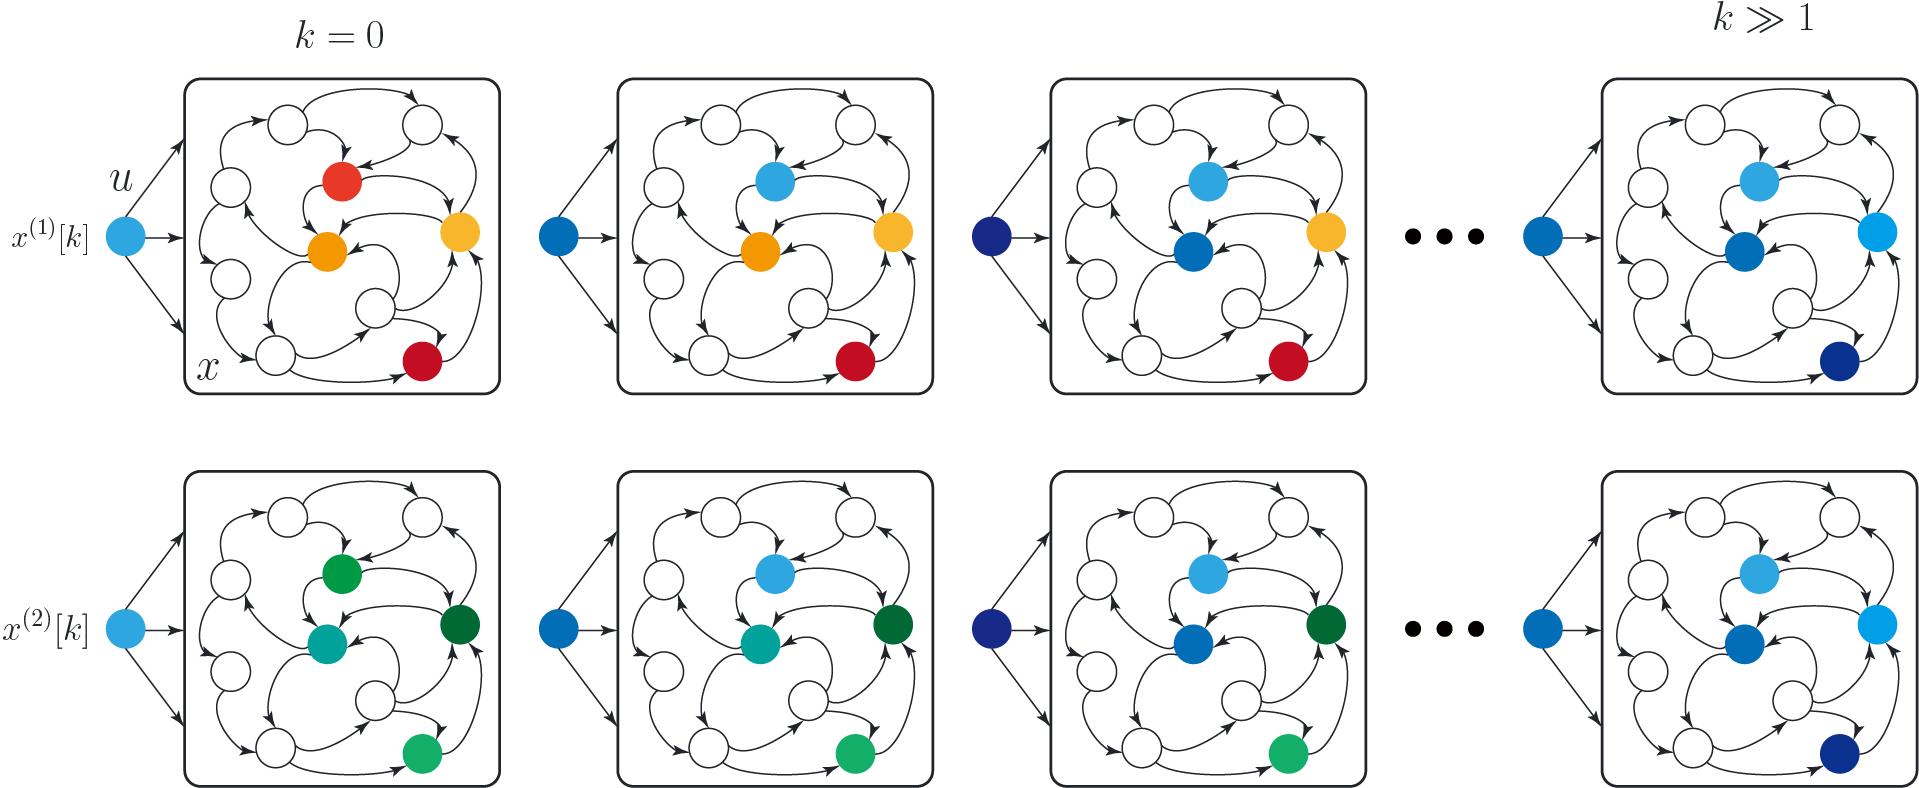
</div>

<figcaption align = "center">

Figure 1 The common signal-induced synchronization in ESN

</figcaption>

The ESP is closely related with this phenomenon.
If we apply an identical input series to a dynamical system repeatedly, the dynamics should provide the same state; otherwise, the state interrupts a reproducible output on each trial because the output is calculated by the weighted sum of states.
In other words, the state should be reproducible against input series.
More specifically, the state $x[k]$ should be a function of past input series only, as follows:

$$
\begin{align*}
x[k] = \varphi(u[k], u[k-1],~\ldots)
.\end{align*}
$$

This function is called the **echo function**.
When the state of the system can be expressed as an echo function, we say that the system has the ESP.
The presence or absence of ESP can be confirmed by checking for common signal-induced synchronization.
Define the distance between two trajectories at time $t$ as follows:

$$
\begin{align*}
d[k] = ||x^{(1)}[k] - x^{(2)}[k]||_2
,\end{align*}
$$

where $||\cdot||_2$ is the L2 norm.
The time average of this distance is defined as follows:

$$
\begin{align*}
\bar{d} = \frac{1}{S} \sum_{k=T-S+1}^{T} d[k]
.\end{align*}
$$

This indicator is called the **ESP index**<sup>[12]</sup> and is sometimes used as a measure of ESP.
Here, $S$ is a parameter representing the length of time steps used to calculate the indicator.

Q4.2.

Fill in the blanks in the following code to implement the function `calc_esp_index` that calculates the ESP index.
The arguments are a multidimensional array $X = [X^{(1)}, X^{(2)}] \in \mathbb{R}^{T\times 2 \times \cdots \times N} $ that stores two trajectories, and the number of timesteps $S \in \mathbb{Z}$ used for calculating the index.

- `calc_esp_index`
  - Argument(s):
    - `xs`: `np.ndarray`
      - `shape`: `(t, 2, ..., n)`
    - `S`: `int`
  - Return(s):
    - `d_bar`: `np.ndarray`
      - `shape`: `(...,)`

<details><summary>tips</summary>

</details>

In [ ]:
def calc_esp_index(xs, S):
    # TODO
    x1 = xs[-S:, 0]
    x2 = xs[-S:, 1]
    ds = np.linalg.norm(x1 - x2, axis=-1)
    d_bar = np.mean(ds, axis=0)
    return d_bar
    # end of TODO


test_func(calc_esp_index, "04_02")
# show_solution("04_02", "calc_esp_index")  # Uncomment it to see the solution.

The sample code below measures the conditional Lyapunov exponents and ESP index when Gaussian noise is provided as input.
The spectral radius $\rho$ and input scaling $\sigma$ of the ESN are experiment variables.

As mentioned many times, a larger $\rho$ leads to a larger maximum Lyapunov exponent (MLE) and stronger chaos.
On the other hand, as $\sigma$ increases, the MLE decreases, due to the effect of noise-induced order.
Furthermore, by comparing the left and right diagrams, the relationship between MLE and the ESP index becomes clear.
When the MLE is negative or close to $0$, the trajectories with different initial states do not diverge, resulting in an ESP index close to $0$.
Conversely, under chaotic conditions where the MLE is positive, the ESP index takes positive values, indicating that the ESP does not hold.

In [ ]:
seed = 7778
dim = 100
rhos = np.linspace(1.0, 1.5, 11)
sigmas = np.linspace(0.0, 1.0, 11)
t_washout = 1000
t_eval = 1000
t_esp_index = 500  # S

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rhos[:, None], rnd=rnd)
w_in = Linear(1, dim, bound=1.0, rnd=rnd)
ts = np.arange(-t_washout, t_eval)
us = rnd.normal(size=(ts.shape[0], 1))
vs = w_in(us)
x0 = rnd.uniform(-1, 1, (2, len(sigmas), len(rhos), dim))
x0[1] = x0[0] + 0.001

x = x0
xs = np.zeros((ts.shape[0], *x.shape))  # (t, 2, sigmas, rhos, dim)
for idx in trange(ts.shape[0]):
    x = net(x, sigmas[:, None, None] * vs[idx])
    xs[idx] = x


esp_indexs = calc_esp_index(xs, t_esp_index)
_lmbds, cond_lyaps = calc_max_lyapunov_exponent(
    lambda x, idx: net(x, sigmas[:, None, None] * vs[t_washout + idx]),
    xs[t_washout + 1, 0],
    t_eval,
    display=True,
)

# Plotting
fig = Figure(figsize=(18, 8))
fig.create_grid(1, 2, wspace=0.5)
fig[0].plot_matrix(cond_lyaps, x=rhos, y=sigmas, zscale="centered", cmap="bwr")
fig[1].plot_matrix(esp_indexs, x=rhos, y=sigmas)
fig[0].set_xlabel(r"$\rho$")
fig[0].set_ylabel(r"$\sigma$")
fig[0].set_title("Conditional MLE")
fig[1].set_xlabel(r"$\rho$")
fig[1].set_ylabel(r"$\sigma$")
fig[1].set_title("ESP index")

None

## References

[1] Alligood, K. T., Sauer, T. D., & Yorke, J. A. (1997). *Chaos. An Introduction to Dynamical Systems*, New York: Springer-Verlag.

[2] Strogatz, S. H. (1994). *Nonlinear Dynamics and Chaos*, Boston: Perseus Books Publishing.

[3] Aihara, K., Ikeguchi, T., Yamada, Y., & Komuro, M. (2000). [ *Chaos Time-Series Analysis: Basics and Applications* ] *Kaosu Jikeiretsu Kaiseki no Kiso to Oyo*, Sangyo Tosho Co., Ltd.

[4] Sprott, J. C. (2003). *Chaos and Time-Series Analysis*, Oxford University Press, pp.116-117. https://sprott.physics.wisc.edu/chaos/lyapexp.htm

[5] Shimada, I., & Nagashima, T. (1979). *A numerical approach to ergodic problem of dissipative dynamical systems*. Progress of theoretical physics, 61(6), 1605-1616. https://doi.org/10.1143/PTP.61.1605

[6] Matsumoto, K., & Tsuda, I. (1983). *Noise-induced order*. Journal of Statistical Physics, 31(1), 87–106. https://doi.org/10.1007/BF01010923

[7] Pecora, L. M., & Carroll, T. L. (1990). *Synchronization in chaotic systems*. Physical Review Letters, 64(8), 821–824. https://doi.org/10.1103/PhysRevLett.64.821

[8] Afraimovich, V. S., Verichev, N. N., & Rabinovich, M. I. (1986). *Stochastic synchronization of oscillation in dissipative systems*. Radiophysics and Quantum Electronics, 29(9), 795–803. https://doi.org/10.1007/BF01034476

[9] Rulkov, N. F., Sushchik, M. M., Tsimring, L. S., & Abarbanel, H. D. I. (1995). *Generalized synchronization of chaos in directionally coupled chaotic systems*. Physical Review E, 51(2), 980–994. https://doi.org/10.1103/PhysRevE.51.980

[10] Kocarev, L., & Parlitz, U. (1996). *Generalized Synchronization, Predictability, and Equivalence of Unidirectionally Coupled Dynamical Systems*. Physical Review Letters, 76(11), 1816–1819. https://doi.org/10.1103/PhysRevLett.76.1816

[11] Lu, Z., Hunt, B., & Ott, E. (2018). *Attractor reconstruction by machine learning*, Chaos: An Interdisciplinary Journal of Nonlinear Science, 28(6), 061104. https://doi.org/10.1063/1.5039508

[12] Gallicchio, C. (2019). *Chasing the Echo State Property*, ESANN 2019 Proceedings. https://www.esann.org/sites/default/files/proceedings/legacy/es2019-76.pdf